# Comparing non-dp decision tree vs dp decision tree

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import diffprivlib.models as dp
from snsynth import Synthesizer # TODO: Exception: Expected exactly one binary to be present. Got: []

In [65]:
# Original data
maternal_health = pd.read_csv('maternalHealthDataSet.csv')
X = maternal_health[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']]
y = maternal_health['RiskLevel']

## Method 0 (No noise added)

In [66]:
def dtree(X, y):
    clf = DecisionTreeClassifier()
    
    # Evaluate the model 
    accuracy = cross_val_score(clf, X, y, cv=10).mean()
    return accuracy

dtree(X, y)

np.float64(0.8134245777518929)

## Method 1 (BASE CASE) (DP Decision Tree, Original Data)

In [99]:
def dp_dtree(epsilon):
    classes = (0, 1, 2) # 0=low risk, 1=mid risk, 2=high risk
    
    # Bounds computer with publicly available domain knowlegde
    # Age, Systolic BP, Diastolic BP, BS, Body Temp, Heart Rate
    bounds = ([1, 50, 50, 60, 95, 60],[125, 170, 170, 130, 103, 100])
    
    
    dp_clf = dp.DecisionTreeClassifier(epsilon=epsilon, bounds=bounds, classes=classes)
    # Evaluate the model 
    accuracy = cross_val_score(dp_clf, X, y, cv=10).mean()
    return accuracy
    
dp_dtree(1.0)

np.float64(0.4654824305960007)

In [100]:
def create_synthesizer(epsilon, delta):
    # MST synthesizer is used here since it took 1st place in NIST's DP syntehtic data contest
    synth = Synthesizer.create("mst", epsilon=epsilon, delta=delta, verbose=True)
    synth.fit(maternal_health[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'RiskLevel']], preprocessor_eps=epsilon/5) # allocate 1/5 of epsilon to the preprocesser
    return synth

def dp_synth_dtree(synth, samples):
    data = synth.sample(samples)
    X_synth = data[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']]
    y_synth = data['RiskLevel']
    return dtree(X_synth, y_synth)

## Effect of samples on models trained with synthetic data

In [93]:
synth = create_synthesizer(1.0, 1e-5)

Spent 0.2 epsilon on preprocessor, leaving 0.8 for training
Fitting with 72960000 dimensions
Getting cliques
Estimating marginals


In [94]:
samples = [10**n for n in range(3, 7)]
accuracies = []
for n in samples:
    accuracies.append(dp_synth_dtree(synth, n))

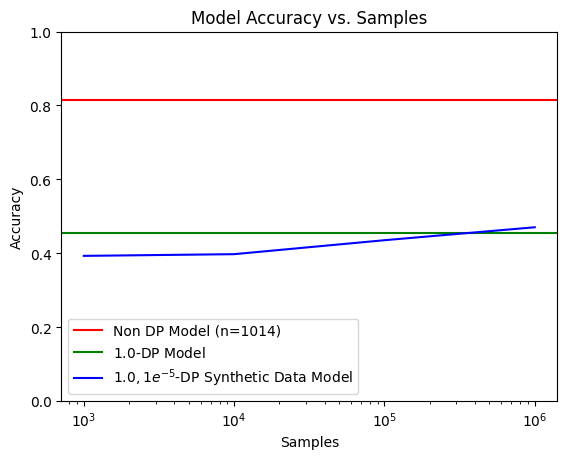

In [95]:
plt.title("Model Accuracy vs. Samples")
plt.xscale("log")
plt.xlabel("Samples")
plt.ylabel("Model Accuracy")
plt.ylim(0, 1.0)

plt.axhline(dtree(X,y), color='r') # plot base accuracy of model
plt.axhline(dp_dtree(1.0), color='g') # plot accuracy of dp decision tree
plt.plot(samples, accuracies, color='b') # plot accuracy of dp synthetic data 
plt.legend([f'Non DP Model (n={len(X)})', r'$1.0$-DP Model', r'$1.0, 1e^{-5}$-DP Synthetic Data Model']) 
plt.show()

## Effect of epsilon on DP Model vs DP Synthetic Data Model

In [107]:
epsilons = [0.5, 1.0, 2.0, 5.0, 10.0]
dp_dtree_acc = []
synth_acc = []
for epsilon in epsilons:
    dp_dtree_acc.append(dp_dtree(epsilon))
    
    synth = create_synthesizer(epsilon, 1e-5)
    synth_acc.append(dp_synth_dtree(synth, 1000))

Spent 0.1 epsilon on preprocessor, leaving 0.4 for training
Fitting with 72960000 dimensions
Getting cliques
Estimating marginals
Spent 0.2 epsilon on preprocessor, leaving 0.8 for training
Fitting with 72960000 dimensions
Getting cliques
Estimating marginals
Spent 0.4 epsilon on preprocessor, leaving 1.6 for training
Fitting with 72960000 dimensions
Getting cliques
Estimating marginals
Spent 1.0 epsilon on preprocessor, leaving 4.0 for training
Fitting with 72960000 dimensions
Getting cliques
Estimating marginals
Spent 2.0 epsilon on preprocessor, leaving 8.0 for training
Fitting with 72960000 dimensions
Getting cliques
Estimating marginals


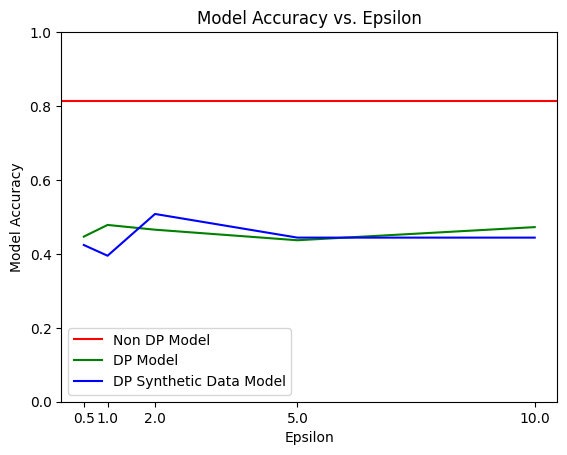

In [109]:
plt.title("Model Accuracy vs. Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Model Accuracy")
plt.ylim(0, 1.0)
plt.xticks(epsilons)

plt.axhline(dtree(X,y), color='r') # plot base accuracy of model
plt.plot(epsilons, dp_dtree_acc, color='g') # plot accuracy of dp decision tree
plt.plot(epsilons, synth_acc, color='b') # plot accuracy of dp synthetic data 
plt.legend([f'Non DP Model', r'DP Model', r'DP Synthetic Data Model']) 
plt.show()